In [611]:
import numpy as np
import json
from collections import defaultdict, Counter
from scipy import spatial, stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.ticker as mtick

In [353]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'
AGG_EMBED_PATH = LOGS + 'semantics_mano/agg_embed/'

## Inspecting individual words

Note that the axes in the wrong direction, e.g. all positive values mean the word leans more towards the opposite of the synset name, while move negative means it is more related to the synset name. This is why "soured" shows up as a prominent positive axis for "sweet girl", etc. 

In [354]:
with open(LOGS + 'semantics_mano/results/scores.json', 'r') as infile: 
    scores = json.load(infile) 

vocab_order = []
with open(LOGS + 'semantics_mano/results/vocab_order.txt', 'r') as infile:
    vocab_order = infile.readlines()

with open(LOGS + 'coref_results/mano_gender_labels.json', 'r') as infile: 
    gender_labels = json.load(infile)

In [355]:
word_poles = defaultdict(Counter) # {word : {pole : score}}
for pole in scores: 
    s = scores[pole]
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        word_poles[term][pole] = s[i]

In [9]:
print(word_poles['alpha'].most_common()[:10])
print(word_poles['alpha'].most_common()[-10:])

[('covered.a.01', 0.25558773434051607), ('clothed.a.01', 0.20460857317052156), ('affected.a.01', 0.19743399192574534), ('busy.a.01', 0.19340250274625598), ('heavy.a.01', 0.1636908153666239), ('mature.a.01', 0.16354657637493), ('androgynous.a.02', 0.15458037457221652), ('delicate.a.01', 0.15350429755099337), ('experienced.a.01', 0.14051773941321305), ('limited.a.01', 0.14049881094011013)]
[('thick.a.01', -0.15037315269704593), ('right.a.04', -0.1534961767732639), ('upland.a.01', -0.15577203865108905), ('capitalistic.a.01', -0.16656310684758813), ('reasonable.a.01', -0.17066723676667722), ('enthusiastic.a.01', -0.17872971894421674), ('optimistic.a.01', -0.182795450552113), ('fat.a.01', -0.2067701379119683), ('moral.a.01', -0.2303085749221428), ('assertive.a.01', -0.26428843033663973)]


In [10]:
print(word_poles['beta'].most_common()[:10])
print(word_poles['beta'].most_common()[-10:])

[('clothed.a.01', 0.2302962468802881), ('busy.a.01', 0.22930095475453216), ('covered.a.01', 0.219025675618927), ('heavy.a.01', 0.20749793146852147), ('experienced.a.01', 0.20338786825387173), ('affected.a.01', 0.18867313060161872), ('active.a.03', 0.17924688026636332), ('visible.a.01', 0.17472462286340498), ('heavy.a.04', 0.16004797618931815), ('stressed.a.02', 0.15305906321978352)]
[('harmless.a.01', -0.1537984253997058), ('auspicious.a.01', -0.15603754767041586), ('quiet.a.02', -0.15667051373894447), ('capitalistic.a.01', -0.15725929069852884), ('defiant.a.01', -0.16001385997621265), ('assertive.a.01', -0.16640615169659442), ('pleasing.a.01', -0.17419947414924292), ('reasonable.a.01', -0.19200510196082082), ('moral.a.01', -0.19343655301123647), ('optimistic.a.01', -0.20350268094208734)]


In [11]:
print(word_poles['escort'].most_common()[:10])
print(word_poles['escort'].most_common()[-10:])

[('visible.a.01', 0.22309017709915227), ('tough.a.01', 0.213360012645474), ('settled.a.02', 0.19296624720667427), ('used.a.01', 0.1857999460473453), ('inclined.a.02', 0.1457751942450308), ('genuine.a.01', 0.144264839289096), ('heavy.a.04', 0.13563279490208444), ('mature.a.01', 0.12739001348117515), ('mindful.a.01', 0.12420469830860567), ('definite.a.01', 0.12353489816582765)]
[('enchanted.a.01', -0.1297488955033736), ('smooth.a.01', -0.13000566120988905), ('serviceable.a.01', -0.1453235611522138), ('east.a.01', -0.15217072046089813), ('assertive.a.01', -0.1561224887165856), ('optimistic.a.01', -0.1587276536999621), ('foreign.a.02', -0.16007725646172424), ('blond.a.01', -0.16609265606499185), ('enthusiastic.a.01', -0.17101999786777775), ('vertical.a.01', -0.1960913578840736)]


In [12]:
print(word_poles['wife'].most_common()[:10])
print(word_poles['wife'].most_common()[-10:])

[('stressed.a.02', 0.1642349879986019), ('communicative.a.02', 0.1548538037300795), ('shod.a.01', 0.1543340554310427), ('inclined.a.02', 0.147667724371479), ('used.a.01', 0.11680373567631179), ('nascent.a.01', 0.11622444489836678), ('practical.a.01', 0.11315294289782041), ('clothed.a.01', 0.11043103649144768), ('androgynous.a.02', 0.1101759594250323), ('worthy.a.01', 0.10829729959320025)]
[('prejudiced.a.02', -0.11483809209471618), ('refined.a.01', -0.11657568793466172), ('rural.a.01', -0.12230937551930993), ('sincere.a.01', -0.1348905506471321), ('enthusiastic.a.01', -0.14627547671047186), ('pleasing.a.01', -0.1476187306605714), ('vertical.a.01', -0.1505769589603431), ('indulgent.a.01', -0.17271745348962464), ('womanly.a.01', -0.2510947708161832), ('blond.a.01', -0.26228053180066013)]


In [13]:
print(word_poles['celebrities'].most_common()[:10])
print(word_poles['celebrities'].most_common()[-10:])

[('tough.a.01', 0.17081688060138467), ('heavy.a.04', 0.16985555976159045), ('shod.a.01', 0.16921350151419515), ('formal.a.01', 0.16257934295405002), ('rational.a.01', 0.1539584724003656), ('clearheaded.a.01', 0.15095418273110356), ('practical.a.01', 0.14949227852479552), ('used.a.01', 0.13713366262867435), ('functional.a.01', 0.13655726047751593), ('live.a.01', 0.13282821636469758)]
[('publicized.a.01', -0.16861678299034474), ('indulgent.a.01', -0.1689884056297398), ('fashionable.a.01', -0.17495802324450085), ('assertive.a.01', -0.1790488263955755), ('blond.a.01', -0.18400036903294198), ('honorable.a.02', -0.19386016991548416), ('capitalistic.a.01', -0.20089025110473818), ('enchanted.a.01', -0.2038839316617339), ('optimistic.a.01', -0.219878418645344), ('enthusiastic.a.01', -0.2702015404193948)]


In [14]:
print(word_poles['princes'].most_common()[:10])
print(word_poles['princes'].most_common()[-10:])

[('tough.a.01', 0.1805231952555273), ('present.a.01', 0.16453077107531805), ('modern.a.01', 0.1598416223346724), ('tough.a.03', 0.1524890905554785), ('used.a.01', 0.1516182763602973), ('surface.a.01', 0.1467284602966408), ('androgynous.a.02', 0.14105737420570597), ('shod.a.01', 0.13003690030581358), ('empirical.a.01', 0.12563998245363733), ('settled.a.02', 0.11645714677201925)]
[('refined.a.01', -0.15650710977105559), ('moral.a.01', -0.1566110449753308), ('glorious.a.01', -0.15852079714472445), ('assertive.a.01', -0.17072084941067336), ('rhetorical.a.02', -0.1747360461794557), ('honorable.a.02', -0.17498177536861484), ('auspicious.a.01', -0.1800081524016834), ('gracious.a.01', -0.190434756294191), ('pleasing.a.01', -0.19060802410015823), ('noble.a.02', -0.43068912052829506)]


In [15]:
print(word_poles['normies'].most_common()[:10])
print(word_poles['normies'].most_common()[-10:])

[('fragrant.a.01', 0.23376121381115872), ('clean.a.01', 0.23125052308491592), ('superior.a.01', 0.22022119417854905), ('educated.a.01', 0.21966800373108855), ('mindful.a.01', 0.2182822500174266), ('busy.a.01', 0.21826220544904631), ('settled.a.02', 0.21495180240785697), ('modest.a.01', 0.21196934804280826), ('careful.a.01', 0.20642503539056628), ('humorous.a.01', 0.20533699336294906)]
[('nonproprietary.a.01', -0.12804204739587602), ('wet.a.01', -0.13109088872897956), ('proud.a.01', -0.14986895208471712), ('moral.a.01', -0.1507341828212458), ('simple.a.01', -0.15215763433495405), ('conscious.a.02', -0.15456060351936168), ('prejudiced.a.02', -0.1595962284843616), ('selfish.a.01', -0.2134563069472661), ('ordinary.a.01', -0.23051900162149913), ('fat.a.01', -0.23554981095825875)]


In [16]:
print(word_poles['simps'].most_common()[:10])
print(word_poles['simps'].most_common()[-10:])

[('clean.a.01', 0.2604844388082124), ('serious.a.01', 0.2527842823082931), ('definite.a.01', 0.24164403889662878), ('conventional.a.04', 0.23772145187427085), ('abstemious.a.01', 0.22977715695462214), ('careful.a.01', 0.216644847990057), ('gracious.a.01', 0.21475233326039692), ('cautious.a.01', 0.21308335759125957), ('tasteful.a.01', 0.2048277942128987), ('busy.a.01', 0.20080071600078564)]
[('cheerful.a.01', -0.13711930530631397), ('flexible.a.02', -0.13992376426055217), ('quiet.a.01', -0.14082034815067648), ('flexible.a.01', -0.1432322652076855), ('nonproprietary.a.01', -0.1515342433042608), ('changeable.a.02', -0.15319182252356459), ('indulgent.a.01', -0.16091865765036034), ('simple.a.01', -0.17922892126620177), ('proud.a.01', -0.216327865672561), ('fat.a.01', -0.281288708181036)]


In [17]:
print(word_poles['prostitute'].most_common()[:10])
print(word_poles['prostitute'].most_common()[-10:])

[('used.a.01', 0.2738366691962819), ('clothed.a.01', 0.23937097872188579), ('settled.a.02', 0.2291109180309099), ('genuine.a.01', 0.20774164855996033), ('reputable.a.01', 0.2034176074242275), ('free.a.01', 0.20046270103216252), ('safe.a.01', 0.19728634455816058), ('superior.a.01', 0.18511084056671884), ('visible.a.01', 0.18354977985627313), ('careful.a.01', 0.1824616231531639)]
[('assertive.a.01', -0.1599361735706449), ('capitalistic.a.01', -0.16414326236623333), ('tired.a.01', -0.17383875787119737), ('optimistic.a.01', -0.17687235032425183), ('commercial.a.01', -0.18044915161152808), ('corrupt.a.01', -0.18965010845156033), ('womanly.a.01', -0.19693576109523947), ('blond.a.01', -0.1993103340935537), ('indulgent.a.01', -0.21088796861255577), ('prejudiced.a.02', -0.26173099058036536)]


In [18]:
print(word_poles['sweet girl'].most_common()[:10])
print(word_poles['sweet girl'].most_common()[-10:])

[('soured.a.01', 0.2993762680324553), ('old.a.01', 0.24585196920696173), ('large.a.01', 0.23454624090201942), ('demanding.a.01', 0.20686306185232417), ('busy.a.01', 0.197643275722586), ('distant.a.02', 0.189853979436521), ('used.a.01', 0.18674327001249796), ('tough.a.03', 0.1843033060276611), ('much.a.01', 0.1842825865919937), ('cursed.a.01', 0.17506098967106104)]
[('reasonable.a.01', -0.20029725604609822), ('sympathetic.a.04', -0.20576029865844586), ('exculpatory.a.01', -0.2085969624311667), ('refined.a.01', -0.22853918654971514), ('beautiful.a.01', -0.23545727870178343), ('sincere.a.01', -0.2519843280077457), ('optimistic.a.01', -0.2563437773193954), ('pleasing.a.01', -0.2725066810670002), ('kind.a.01', -0.2763736927813124), ('lovable.a.01', -0.3158886668571521)]


In [19]:
print(word_poles['thot'].most_common()[:10])
print(word_poles['thot'].most_common()[-10:])

[('definite.a.01', 0.1942506848860781), ('clean.a.01', 0.1673035189706998), ('improved.a.01', 0.16144572589832623), ('motivated.a.01', 0.152628178859815), ('conventional.a.04', 0.14834912226141417), ('assisted.a.01', 0.14402170982564783), ('gracious.a.01', 0.14375817406252167), ('exempt.a.01', 0.1386175631587233), ('meaningful.a.01', 0.1376077435672449), ('stable.a.01', 0.13545902803716559)]
[('strange.a.01', -0.10258656068959875), ('flexible.a.02', -0.10486797902865443), ('satisfactory.a.01', -0.11070000339932176), ('thinkable.a.01', -0.11700241756682321), ('credulous.a.01', -0.12267252067925646), ('fat.a.01', -0.12638101965574716), ('nonproprietary.a.01', -0.12937259858528127), ('old.a.02', -0.13903732562136084), ('same.a.01', -0.15038574864936355), ('distant.a.01', -0.20976531914767527)]


In [20]:
print(word_poles['women'].most_common()[:10])
print(word_poles['women'].most_common()[-10:])

[('stressed.a.02', 0.2689686041765973), ('androgynous.a.02', 0.26615011162215274), ('used.a.01', 0.17418508989923898), ('shod.a.01', 0.17415410665801528), ('heavy.a.04', 0.15623034942651035), ('clothed.a.01', 0.14830480731774676), ('worthy.a.01', 0.14272245389365118), ('resolute.a.01', 0.13329823016528006), ('sacred.a.01', 0.13287332282955855), ('protected.a.01', 0.12342149919623766)]
[('selfish.a.01', -0.12718445486502283), ('capitalistic.a.01', -0.12951324600671643), ('hot.a.03', -0.1325397538418296), ('graceful.a.01', -0.1355055651284687), ('pleasing.a.01', -0.13815785044580048), ('indulgent.a.01', -0.17790987421169782), ('shapely.a.01', -0.18686821149604158), ('prejudiced.a.02', -0.2406379872123752), ('blond.a.01', -0.32147493747143213), ('womanly.a.01', -0.5140653893774207)]


# Variance within gender

In [371]:
fem_variance = Counter() # {pole: variance of fem terms}
fem_extremes = defaultdict(tuple) # {pole: (top N terms, bottom N terms)}
masc_variance = Counter() 
masc_extremes = defaultdict(tuple)
fem_scores = defaultdict(list) # {pole: scores in order of x_words}
masc_scores = defaultdict(list) # {pole: scores in order of y_words}
N = 3
for pole in scores: 
    s = scores[pole]
    x = [] # fem scores
    x_words = []
    y = [] # masc scores
    y_words = []
    for i, term in enumerate(vocab_order): 
        term = term.strip()
        if term in gender_labels: 
            if gender_labels[term] > 0.75: 
                x.append(s[i])
                x_words.append(term)
            elif gender_labels[term] < 0.25: 
                y.append(s[i])
                y_words.append(term)
    fem_variance[pole] = np.var(x)
    indices = np.argpartition(x, -N)[-N:]
    topN = [x_words[idx].strip() for idx in indices]
    indices = np.argpartition(x, N)[:N]
    bottomN = [x_words[idx].strip() for idx in indices]
    fem_extremes[pole] = (topN, bottomN, min(x), max(x))
    fem_scores[pole] = x
    
    masc_variance[pole] = np.var(y)
    indices = np.argpartition(y, -N)[-N:]
    topN = [y_words[idx].strip() for idx in indices]
    indices = np.argpartition(y, N)[:N]
    bottomN = [y_words[idx].strip() for idx in indices]
    masc_extremes[pole] = (topN, bottomN, min(y), max(y))
    masc_scores[pole] = y

In [419]:
for tup in fem_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = fem_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('womanly.a.01', 0.0207367739111438)
TOP: ['hambeast', 'tomboys', 'tomboy']
BOTTOM: ['female gender', 'feminine women', 'feminine woman']
-0.5856429849438389 0.36751912466938597

('androgynous.a.02', 0.01048472108047411)
TOP: ['white females', 'female', 'females']
BOTTOM: ['manipulative bitch', 'nympho', 'noodlewhore']
-0.19918680740902128 0.4108695695846027

('lovable.a.01', 0.010376138902053338)
TOP: ['woman haters', 'women haters', 'degenerate whores']
BOTTOM: ['little princess', 'sweet girl', 'beautiful girl']
-0.3158886668571521 0.4004010633757613

('reputable.a.01', 0.008525157638178259)
TOP: ['slut', 'dirty slut', 'sluts']
BOTTOM: ['great wife', 'great woman', 'great women']
-0.14964813563467744 0.4022180094944489

('wholesome.a.01', 0.00843521055871161)
TOP: ['evil bitch', 'dirty slut', 'degenerate whores']
BOTTOM: ['healthy woman', 'healthy women', 'homemakers']
-0.24472081446745786 0.3657217434203625

('clean.a.01', 0.007831925252821238)
TOP: ['club sluts', 'hambeasts', 'harl

In [420]:
for tup in masc_variance.most_common(20): 
    print(tup)
    pole = tup[0]
    topN, bottomN, mi, ma = masc_extremes[pole]
    print("TOP:", topN)
    print("BOTTOM:", bottomN)
    print(mi, ma)
    print()

('androgynous.a.02', 0.012188110400550777)
TOP: ['dominant males', 'male', 'males']
BOTTOM: ['manipulator', 'hypocrites', 'hypocrite']
-0.2604874475023576 0.44170802824635863

('womanly.a.01', 0.01105276724502953)
TOP: ['wimp', 'wanker', 'goober']
BOTTOM: ['feminine men', 'male gender', 'male feminist']
-0.5029534793157493 0.29910455279596726

('reputable.a.01', 0.009900774126213017)
TOP: ['misogynists', 'misogynist', 'wimp']
BOTTOM: ['great men', 'great people', 'great leader']
-0.22716405597214687 0.3987890193065139

('lovable.a.01', 0.009518692849910448)
TOP: ['hater', 'traitors', 'haters']
BOTTOM: ['little angel', 'sweet guy', 'beautiful man']
-0.2916932595371912 0.3965976053049023

('wholesome.a.01', 0.00925771584422821)
TOP: ['fucking hypocrite', 'buffoon', 'fucking hypocrites']
BOTTOM: ['healthy male', 'healthy man', 'healthy men']
-0.24359662484688357 0.3695135063377389

('intellectual.a.02', 0.00856525720854899)
TOP: ['circumcised man', 'hypocrite', 'uncircumcised men']
BOTTOM

## Axes similarities for each clusters' highly gendered terms

In [403]:
with open(LOGS + 'gram_counts/combined_catyear_word_count.json', 'r') as infile: 
    catyear_word_count = json.load(infile)
total_vocab_count = Counter() # {term : count in mano reddit + forum}
for catyear in catyear_word_count: 
    for term in catyear_word_count[catyear]: 
        total_vocab_count[term] += catyear_word_count[catyear][term]
# remove bigram counts from unigrams 
for term in total_vocab_count: 
    if ' ' in term: 
        toks = term.split(' ')
        if toks[0] in total_vocab_count: 
            total_vocab_count[toks[0]] = total_vocab_count[toks[0]] - total_vocab_count[term]
        if toks[1] in total_vocab_count: 
            total_vocab_count[toks[1]] = total_vocab_count[toks[1]] - total_vocab_count[term]
print(total_vocab_count.most_common(20))

[('she', 1760546), ('he', 861007), ('women', 801795), ('man', 604788), ('people', 555328), ('girl', 490864), ('woman', 482506), ('someone', 458890), ('guys', 361499), ('guy', 344341), ('men', 336551), ('girls', 326322), ('anyone', 324551), ('friends', 243747), ('everyone', 238800), ('friend', 228233), ('others', 203092), ('female', 178923), ('person', 174827), ('you guys', 167224)]


In [404]:
with open(LOGS + 'time_series/cluster_members_6.json', 'r') as infile: 
    clust_words = json.load(infile)
clust_words_rev = {}
for clust in clust_words: 
    cluster_words = clust_words[clust]
    for w in cluster_words: 
        clust_words_rev[w] = clust

In [405]:
fem_axes = ['beautiful.a.01', 'lovable.a.01', 'clean.a.01']
masc_axes = ['beautiful.a.01', 'lovable.a.01', 'intellectual.a.02']

### New visualization plan

scatter plot for each axis, x-axis is overall frequency of word, y-axis is score, hue is the cluster number

In [406]:
d = {
    'pole': [], 
    'gender': [],
    'clust_num': [], 
    'word': [], 
    'score': [],
    'frequency': [],
}
for clust_num in cluster_order: 
    for gender in ['fem', 'masc']:
        key = str(clust_num) + '_' + gender
        if gender == 'fem': 
            this_axes = fem_axes
        if gender == 'masc': 
            this_axes = masc_axes
        for pole in this_axes:  
            s = scores[pole]
            for i, term in enumerate(vocab_order): 
                term = term.strip()
                if str(clust_words_rev[term]) != str(clust_num): continue
                if term not in gender_labels: continue
                if gender == 'fem' and gender_labels[term] > 0.75: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])
                if gender == 'masc' and gender_labels[term] < 0.25: 
                    d['pole'].append(pole)
                    d['gender'].append(gender)
                    d['clust_num'].append(clust_num)
                    d['word'].append(term)
                    d['score'].append(s[i])
                    d['frequency'].append(total_vocab_count[term])

In [407]:
cluster_score_df = pd.DataFrame.from_dict(d)
cluster_score_df['log_freq'] = cluster_score_df['frequency'].apply(lambda x: math.log10(x))
clust_num_letter_map = {4 : 'A', 3 : 'B', 5 : 'C', 1 : 'D', 2 : 'E', 0 : 'F'}
cluster_score_df['clust_letter'] = cluster_score_df['clust_num'].apply(lambda x: clust_num_letter_map[x])
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A
...,...,...,...,...,...,...,...,...
10756,intellectual.a.02,masc,0,virgin men,0.063220,892,2.950365,F
10757,intellectual.a.02,masc,0,white chad,-0.040579,2223,3.346939,F
10758,intellectual.a.02,masc,0,white chads,0.038740,878,2.943495,F
10759,intellectual.a.02,masc,0,white incel,0.137710,580,2.763428,F


In [408]:
cluster_score_df[cluster_score_df['word'] == 'women']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
5829,beautiful.a.01,fem,1,women,-0.036429,801795,5.904063,D
6174,lovable.a.01,fem,1,women,-0.065459,801795,5.904063,D
6519,clean.a.01,fem,1,women,-0.002982,801795,5.904063,D


In [409]:
cluster_score_df[cluster_score_df['word'] == 'girls']

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter
2691,beautiful.a.01,fem,3,girls,-0.095671,326322,5.513646,B
3010,lovable.a.01,fem,3,girls,-0.130053,326322,5.513646,B
3329,clean.a.01,fem,3,girls,0.061343,326322,5.513646,B


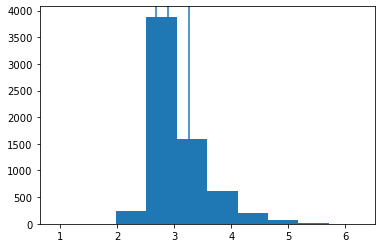

In [410]:
frequencies = [math.log10(i) for i in total_vocab_count.values()]
first_cutoff = np.percentile(frequencies, 1/4*100)
second_cutoff = np.percentile(frequencies, 2/4*100)
third_cutoff = np.percentile(frequencies, 3/4*100)
plt.hist(frequencies)
plt.axvline(first_cutoff)
plt.axvline(second_cutoff)
plt.axvline(third_cutoff)
plt.show()

In [411]:
def get_freq_bucket(x): 
    if x <= third_cutoff:
        return 'bottom 75%'
    else: 
        return 'top 25%'
cluster_score_df['freq_bucket'] = cluster_score_df['log_freq'].apply(get_freq_bucket)
cluster_score_df

,pole,gender,clust_num,word,score,frequency,log_freq,clust_letter,freq_bucket
0,beautiful.a.01,fem,4,1 female,0.036255,700,2.845098,A,bottom 75%
1,beautiful.a.01,fem,4,10 women,-0.002096,2914,3.464490,A,top 25%
2,beautiful.a.01,fem,4,100 girls,-0.062551,1723,3.236285,A,bottom 75%
3,beautiful.a.01,fem,4,15 women,0.029945,426,2.629410,A,bottom 75%
4,beautiful.a.01,fem,4,2 women,0.016124,2053,3.312389,A,top 25%
...,...,...,...,...,...,...,...,...,...
10756,intellectual.a.02,masc,0,virgin men,0.063220,892,2.950365,F,bottom 75%
10757,intellectual.a.02,masc,0,white chad,-0.040579,2223,3.346939,F,top 25%
10758,intellectual.a.02,masc,0,white chads,0.038740,878,2.943495,F,bottom 75%
10759,intellectual.a.02,masc,0,white incel,0.137710,580,2.763428,F,bottom 75%


In [412]:
fem_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'fem']
masc_cluster_score_df = cluster_score_df[cluster_score_df['gender'] == 'masc']

In [654]:
def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)
cluster_order_str = [str(x) for x in cluster_order]
pole_titles = {'beautiful.a.01' : 'beautiful $\leftrightarrow$ ugly',
               'lovable.a.01' : 'lovable $\leftrightarrow$ detestable', 
               'prejudiced.a.02': 'prejudiced $\leftrightarrow$ unprejudiced', 
               'old.a.01': 'old $\leftrightarrow$ young', 
               'clean.a.01': 'clean $\leftrightarrow$ dirty', 
               'educated.a.01': 'knowledgeable $\leftrightarrow$ ignorant',
               'liked.a.01': 'likeable $\leftrightarrow$ unlikable', 
               'heavy.a.04': 'distressful $\leftrightarrow$ casual, light', 
               'delicate.a.01': 'delicate $\leftrightarrow$ tough',
               'intellectual.a.02': 'intellectual $\leftrightarrow$ mindless',
              }

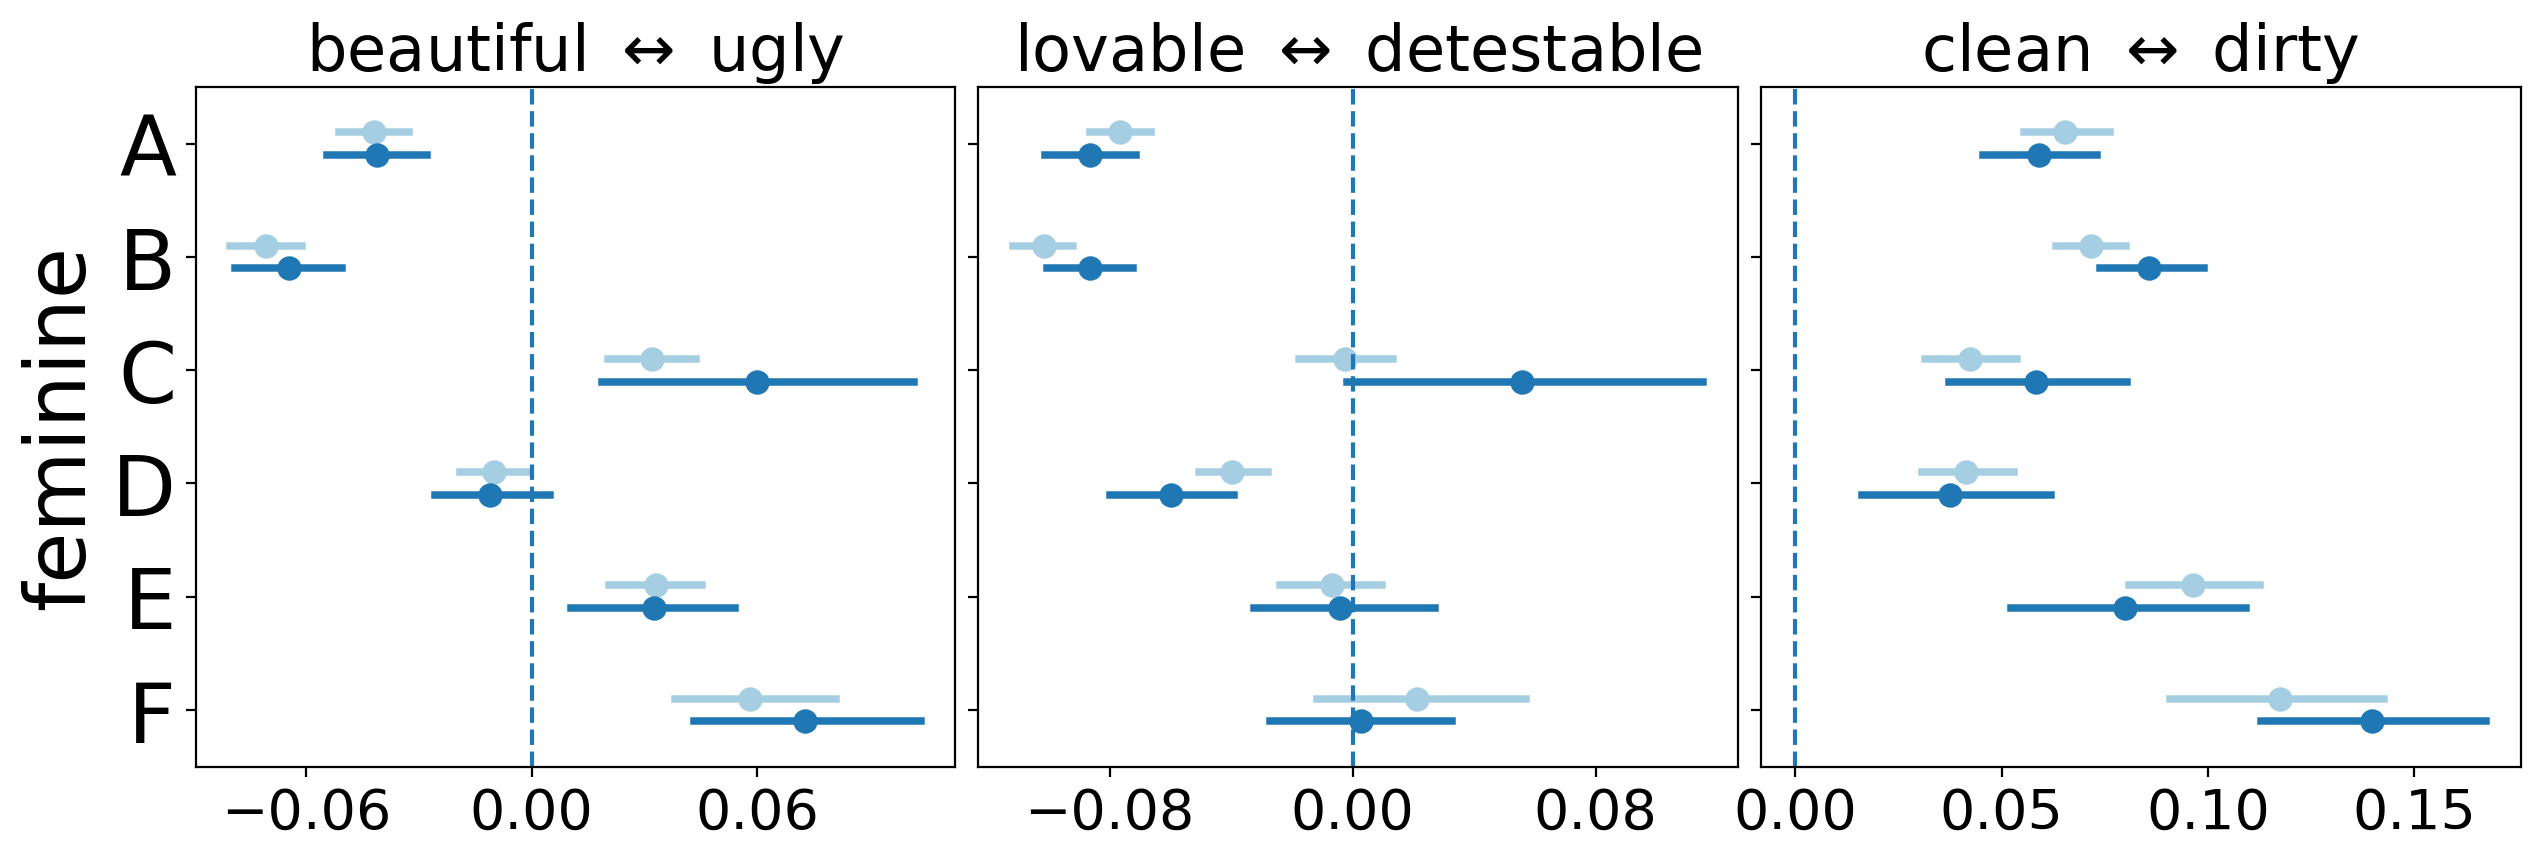

In [658]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), dpi=200, sharey=True)
for order, pole in enumerate(fem_axes): 
    this_df = fem_cluster_score_df[fem_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False, ax=axes[order])
    axes[order].axvline(0, linestyle='--')
    axes[order].set_title(pole_titles[pole], fontsize=23)
    axes[order].get_legend().remove()
    if order == 0: 
        axes[order].set_ylabel('feminine', fontsize=30)
    else: 
        axes[order].set_ylabel('')
    axes[order].set_xlabel('')
    axes[order].yaxis.set_tick_params(labelsize=30)
    axes[order].xaxis.set_major_locator(mtick.MaxNLocator(4))
    axes[order].xaxis.set_tick_params(labelsize=20)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.show()

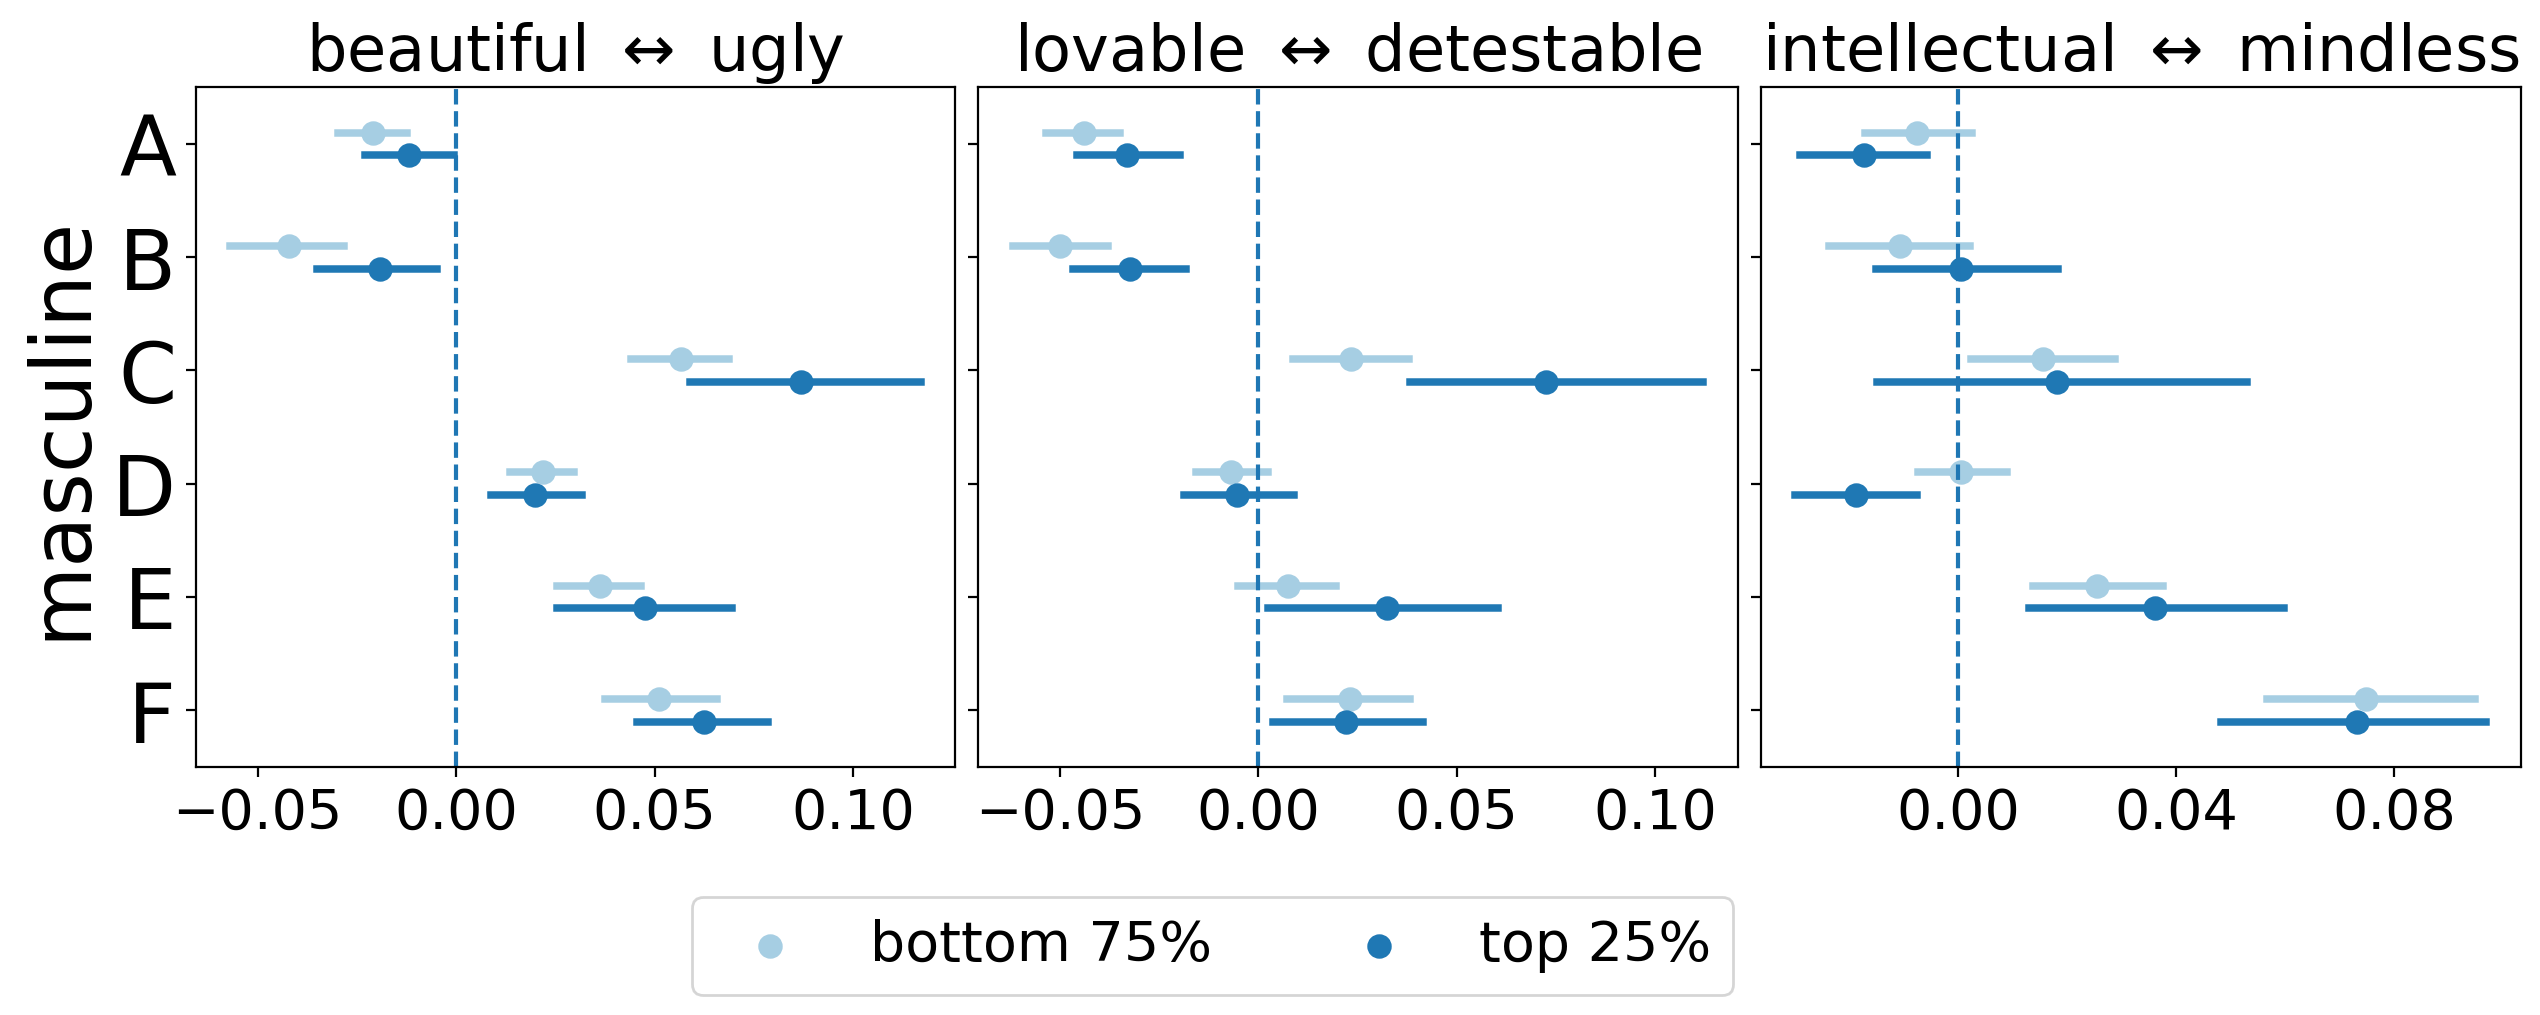

In [657]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), dpi=200, sharey=True)
for order, pole in enumerate(masc_axes): 
    this_df = masc_cluster_score_df[masc_cluster_score_df['pole'] == pole]
    sns.pointplot(x="score", y="clust_letter", hue='freq_bucket', palette="Paired",
                  data=this_df, orient="h", dodge=.2, join=False, ax=axes[order])
    axes[order].axvline(0, linestyle='--')
    axes[order].set_title(pole_titles[pole], fontsize=23)
    axes[order].get_legend().remove()
    if order == 0: 
        axes[order].set_ylabel('masculine', fontsize=30)
    else: 
        axes[order].set_ylabel('')
    axes[order].set_xlabel('')
    axes[order].yaxis.set_tick_params(labelsize=30)
    axes[order].xaxis.set_major_locator(mtick.MaxNLocator(4))
    axes[order].xaxis.set_tick_params(labelsize=20)
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.legend(fontsize=20, bbox_to_anchor=(0.0, -0.15), ncol=2)
plt.show()

## Variants

moids vs. men

femoids, foids, vs. women

In [686]:
VARIANT_OUT = LOGS + 'semantics_mano/variant_scores/'

In [687]:
with open(VARIANT_OUT + 'scores.json', 'r') as infile: 
    variant_scores = json.load(infile)
pole_order = []
with open(VARIANT_OUT + 'pole_order.txt', 'r') as infile: 
    for line in infile:
        pole_order.append(line.strip())

In [690]:
scores_per_word = defaultdict(list)
for key in variant_scores:
    contents = key.split('_')
    scores_per_word[contents[0]].extend(variant_scores[key])
for w in scores_per_word: 
    scores_per_word[w] = np.array(scores_per_word[w])
comparisons = [('men', 'moids'), ('women', 'femoids'), ('women', 'foids')]

In [692]:
for comp in comparisons: 
    print(comp)
    class1 = comp[0]
    class2 = comp[1]
    mean_diff = abs(np.mean(scores_per_word[class1], axis=0) - np.mean(scores_per_word[class2], axis=0))
    ind = np.argpartition(mean_diff, -5)[-5:]
    for idx in ind: 
        print(pole_order[idx],)
    print()

('men', 'moids')
exterior.a.01
wholesome.a.01
rational.a.01
dignified.a.01
meaningful.a.01

('women', 'femoids')
rational.a.01
meaningful.a.01
good.a.03
dignified.a.01
shapely.a.01

('women', 'foids')
abstemious.a.01
trustful.a.01
shapely.a.01
anterior.a.01
meaningful.a.01



In [577]:
# use axes to classify the identity of the word to find out which axes are important for distinguishing them
feat_importances = []
for comp in comparisons: 
    print("running model for", comp)
    class1 = comp[0]
    class2 = comp[1]
    y1 = [0]*scores_per_word[class1].shape[0]
    y2 = [1]*scores_per_word[class2].shape[0]
    y = np.array(y1 + y2)
    X = np.concatenate((scores_per_word[class1], scores_per_word[class2]), axis=0)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)
    feat_importances.append(forest.feature_importances_)

running model for ('men', 'moids')
running model for ('women', 'femoids')
running model for ('women', 'foids')


In [578]:
for i, comp in enumerate(comparisons): 
    print(comp)
    importances = feat_importances[i]
    ind = np.argpartition(importances, -5)[-5:]
    for idx in ind: 
        print(pole_order[idx],)
    print()

('men', 'moids')
long.a.01
related.a.01
dignified.a.01
meaningful.a.01
wholesome.a.01

('women', 'femoids')
wholesome.a.01
lost.a.03
dignified.a.01
meaningful.a.01
good.a.03

('women', 'foids')
good.a.03
empirical.a.01
meaningful.a.01
dignified.a.01
blond.a.01



In [713]:
d = {
    'pole': [], # each row
    'gender': [], # two facets
    'year': [], # x axis
    'community': [],
    'word': [], # hue 
    'score': [], # y axis
}
poles_of_interest = ['good.a.03', 'dignified.a.01']
for key in variant_scores:
    contents = key.split('_')
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        for score_list in variant_scores[key]: 
            if int(contents[-1]) not in [2017, 2018, 2019]: continue
            community = '_'.join(contents[1:len(contents)-1])
            if contents[0] in ['moids', 'men']: 
                gender = 'm'
            elif contents[0] in ['femoids', 'foids', 'women']: 
                gender = 'f'
            # women talking about men or men talking about women
            if (community.startswith('Femcels') or community.startswith('FDS')) and gender == 'f': continue
            if gender == 'm' and not (community.startswith('Femcels') or community.startswith('FDS')): continue
            d['community'].append(community)
            score = score_list[idx]
            d['pole'].append(pole)
            d['word'].append(contents[0])
            d['gender'].append(gender)
            d['year'].append(int(contents[-1]))
            d['score'].append(score)
variant_df = pd.DataFrame.from_dict(d)

In [714]:
variant_df

,pole,gender,year,community,word,score
0,good.a.03,f,2017,red_pill_talk,women,0.030118
1,good.a.03,f,2017,red_pill_talk,women,0.020377
2,good.a.03,f,2017,red_pill_talk,women,0.024679
3,good.a.03,f,2017,red_pill_talk,women,-0.015857
4,good.a.03,f,2017,red_pill_talk,women,0.032558
...,...,...,...,...,...,...
11485,dignified.a.01,f,2017,the_attraction,women,-0.008226
11486,dignified.a.01,f,2017,the_attraction,women,0.028005
11487,dignified.a.01,f,2017,the_attraction,women,0.064735
11488,dignified.a.01,f,2017,the_attraction,women,-0.006836


In [711]:
colors = [sns.color_palette("Paired")[1], 
            sns.color_palette("Paired")[3], 
            sns.color_palette("Paired")[7], 
            sns.color_palette("Paired")[0], 
            sns.color_palette("Paired")[2]
         ]
pole_map = {'good.a.03': 'good $\leftrightarrow$ evil', 
           'dignified.a.01': 'dignified $\leftrightarrow$ pathetic' }

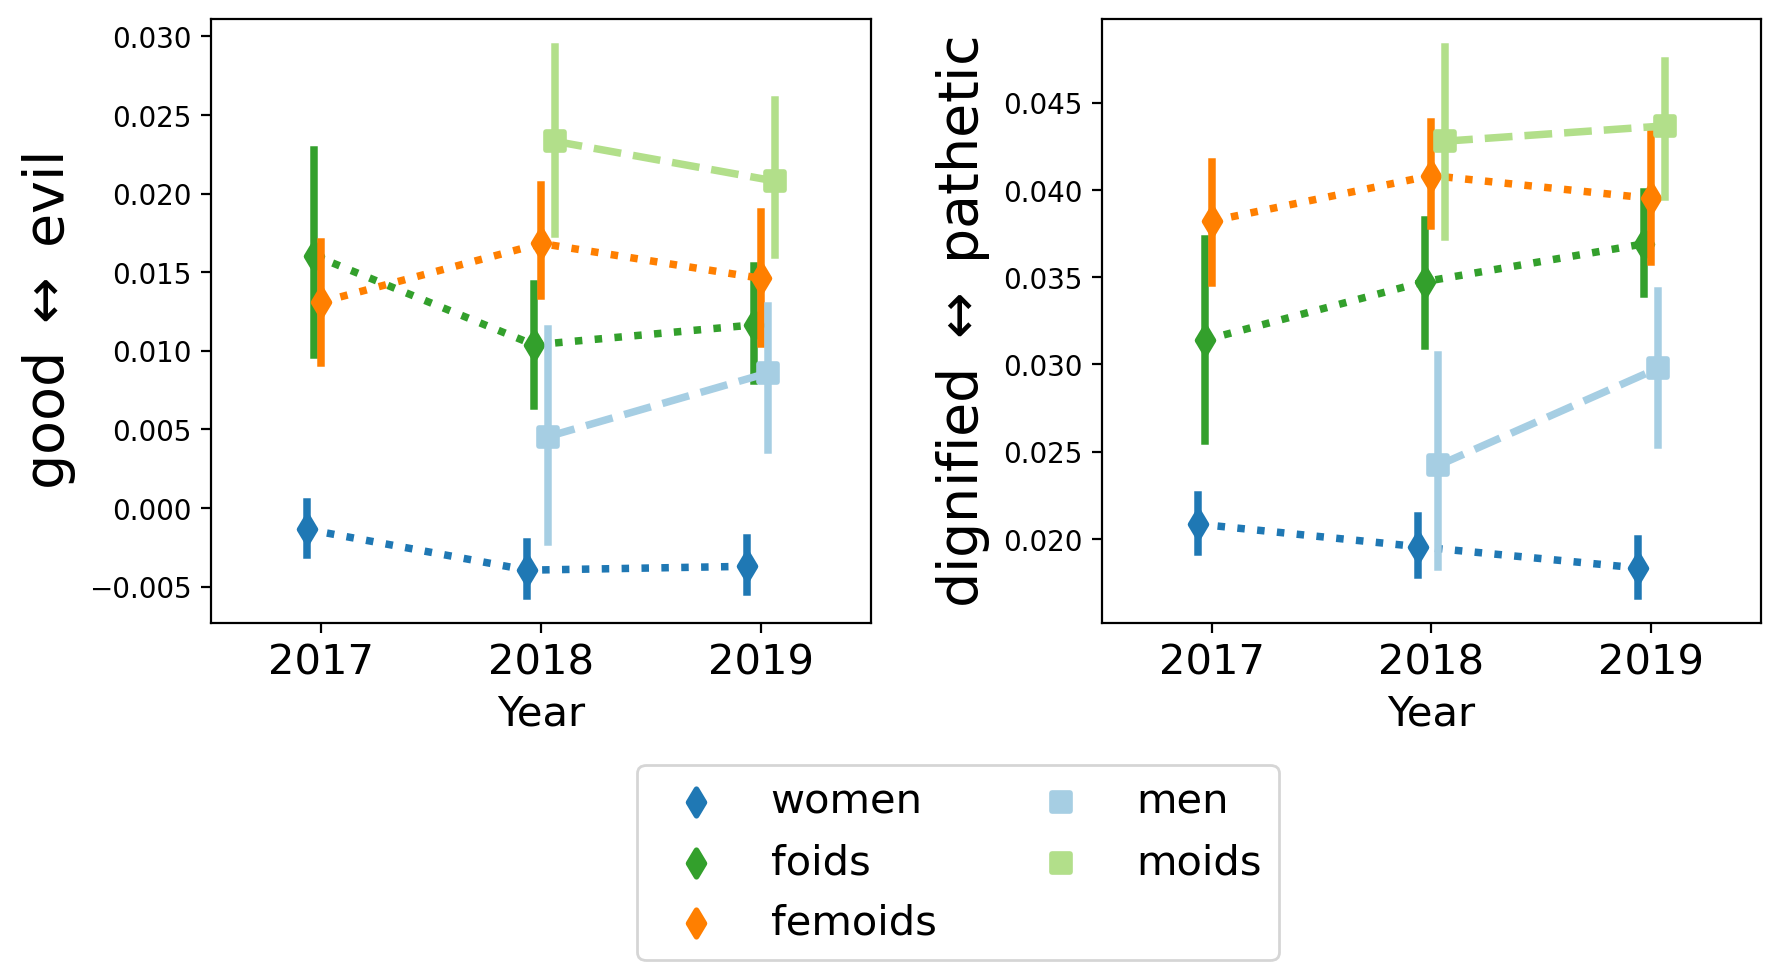

In [736]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
hue_order = ['women', 'foids', 'femoids', 'men', 'moids']
this_df = variant_df[variant_df['pole'] == poles_of_interest[0]]
sns.pointplot(data=this_df, x='year', y='score', hue='word', hue_order=hue_order,
              dodge=True, linestyles=[':', ':', ':', '--', '--'], 
             markers=['d', 'd', 'd', 's', 's'], palette=colors, ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_ylabel(pole_map[poles_of_interest[0]], fontsize=20)
axes[0].set_xlabel('Year', fontsize=15)
axes[0].xaxis.set_tick_params(labelsize=15)

this_df = variant_df[variant_df['pole'] == poles_of_interest[1]]
sns.pointplot(data=this_df, x='year', y='score', hue='word', hue_order=hue_order,
              dodge=True, linestyles=[':', ':', ':', '--', '--'], 
             markers=['d', 'd', 'd', 's', 's'], palette=colors, ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_ylabel(pole_map[poles_of_interest[1]], fontsize=20)
axes[1].set_xlabel('Year', fontsize=15)
axes[1].xaxis.set_tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.35, hspace=0)
plt.legend(fontsize=15, bbox_to_anchor=(0.3, -0.2), ncol=2)
plt.show()

## Women across domains

In [737]:
WOMEN_OUT = LOGS + 'semantics_mano/women_scores/'

In [738]:
with open(WOMEN_OUT + 'scores.json', 'r') as infile: 
    women_scores = json.load(infile)

In [743]:
women_scores.keys()

dict_keys(['feminists_wikipedia', 'women_wikipedia', 'girls_wikipedia', 'females_wikipedia', 'women_control', 'girls_control', 'females_control', 'feminists_control', 'women_extreme', 'girls_extreme', 'females_extreme', 'feminists_extreme'])

In [740]:
d = {
    'pole': [], # each row
    'community': [],
    'word': [], # hue 
    'score': [], # y axis
}
poles_of_interest = ['lovable.a.01']
for key in women_scores:
    contents = key.split('_')
    for pole in poles_of_interest: 
        idx = pole_order.index(pole)
        for score_list in women_scores[key]: 
            d['community'].append(contents[-1])
            score = score_list[idx]
            d['pole'].append(pole)
            d['word'].append(contents[0])
            d['score'].append(score)
women_df = pd.DataFrame.from_dict(d)

In [745]:
women_df

,pole,community,word,score
0,lovable.a.01,wikipedia,feminists,0.088750
1,lovable.a.01,wikipedia,feminists,0.087270
2,lovable.a.01,wikipedia,feminists,0.127052
3,lovable.a.01,wikipedia,feminists,0.128505
4,lovable.a.01,wikipedia,feminists,0.042243
...,...,...,...,...
12478,lovable.a.01,extreme,feminists,0.116103
12479,lovable.a.01,extreme,feminists,0.100012
12480,lovable.a.01,extreme,feminists,0.047686
12481,lovable.a.01,extreme,feminists,0.061600


<AxesSubplot:xlabel='community', ylabel='score'>

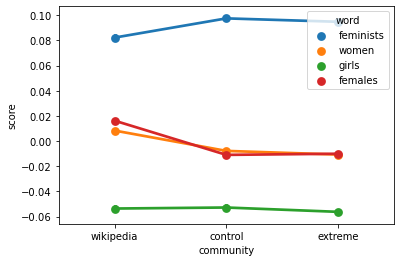

In [744]:
sns.pointplot(data=women_df, x='community', y='score', hue='word')